# Workflows

Workflows in `hyrun` are represented usint the `JobGraph` class. A `JobGraph` instance comprises `hyrun` jobs and their (optional) dependencies in the form of a direct graph using the python package [`networkx`](https://networkx.org). This structure allows the construction and manipulation and analysis of complexed workflows using `hyrun`.

In [1]:
from hyrun.job import JobGraph, Job

## Construction

A `JobGraph` can be constructed from a list of jobs, that provide the hashes that will be the nodes (vertices) and a list of tuples of dependencies, that will be represented by the edges.

In [2]:
jobs = [Job(hash=f'hash{i}', status='unknown') for i in range(7)]
dependencies = [(jobs[i].hash, jobs[j].hash) for (i, j) in [(0, 1), (1, 2), (1, 3), (2, 4)]]

graph = JobGraph(nodes=jobs, edges=dependencies)
print(graph.nodes)
print(graph.edges)

['hash0', 'hash1', 'hash2', 'hash3', 'hash4', 'hash5', 'hash6']
[('hash0', 'hash1'), ('hash1', 'hash2'), ('hash1', 'hash3'), ('hash2', 'hash4')]


A `hyrun.graph.JobGraph` might also be created from jobs without hashes, the node labels are then the indices in which the nodes have been added to the graph.

In [3]:
newgraph = JobGraph(jobs=[Job() for _ in range(7)], dependencies=[(0, 1), (1, 2), (1, 3), (2, 4)])
print(newgraph)

╟── 0
╎   └─╼ 1
╎       ├─╼ 2
╎       │   └─╼ 4
╎       └─╼ 3
╟── 5
╙── 6


Nodes can be relabeled providing the respective mapping:

In [4]:
from copy import copy
newgraph = copy(graph)
newgraph.relabel_nodes({'hash0': 'water1', 'hash1': 'water2'})
print(newgraph)

╟── water1
╎   └─╼ water2
╎       ├─╼ hash2
╎       │   └─╼ hash4
╎       └─╼ hash3
╟── hash5
╙── hash6


## Visualization

A simple overview of the graph with its depencies can be printed like this:

In [5]:
print(graph)

╟── hash0
╎   └─╼ hash1
╎       ├─╼ hash2
╎       │   └─╼ hash4
╎       └─╼ hash3
╟── hash5
╙── hash6



The order in which hyrun processes the jobs may differ from the order of the nodes the graph has been constructed with due to the dependencies.
The correct order in which the jobs run is therefore:

In [6]:
print(graph.topological)

['hash0', 'hash5', 'hash6', 'hash1', 'hash2', 'hash3', 'hash4']


and can be visualized:

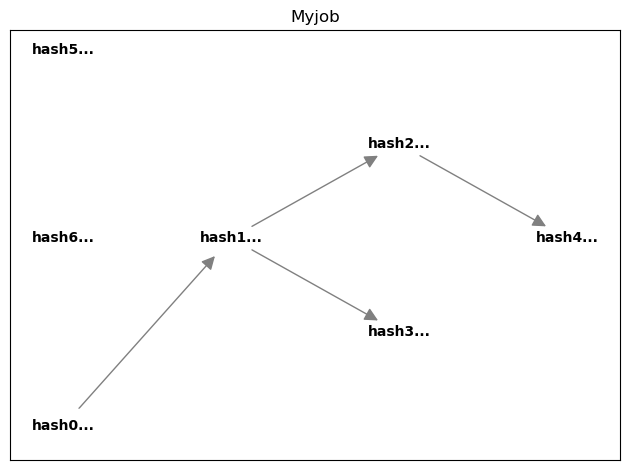

In [7]:
graph.show(title='Myjob')

## Properties

Both nodes and edges can have properties. Per default, status and a db_id are extracted from the jobs.

In [8]:
graph['hash0']['status'] = 'running'
graph['hash1']['status'] = 'running'


for job in graph.nodes:
    if graph[job].get('status') != 'running':
        print(f'job {job} does *not* run')


job hash2 does *not* run
job hash3 does *not* run
job hash4 does *not* run
job hash5 does *not* run
job hash6 does *not* run


In [9]:
graph[('hash0', 'hash1')]['weight'] = 0.5
graph[('hash2', 'hash4')]['weight'] = 0.75

for u, v in graph.edges:
    if graph[(u, v)].get('weight', 0.0) > 0.2:
        print(f'edge {u} -> {v} has weight over 0.2')

edge hash0 -> hash1 has weight over 0.2
edge hash2 -> hash4 has weight over 0.2


## Manipulation

Both nodes and edges can be added and removed.

In [10]:
newgraph = JobGraph(jobs=[Job(hash=f'hash{100+i}') for i in range(4)])
print(newgraph)

╟── hash100
╟── hash101
╟── hash102
╙── hash103


In [11]:
newgraph.add_edge('hash101', 'hash102')
newgraph.remove_node('hash103')
print(newgraph)

╟── hash100
╙── hash101
    └─╼ hash102


Note that per default, removing an edge does not remove any nodes, and thus the graph topology is changed:

In [12]:
newgraph = copy(graph)

newgraph.remove_edge('hash1', 'hash2')
newgraph.remove_node('hash6')
newgraph.add_node(Job(hash='hash7'))
newgraph.add_edge('hash3', 'hash7')
print(newgraph)



╟── hash0
╎   └─╼ hash1
╎       └─╼ hash3
╎           └─╼ hash7
╟── hash2
╎   └─╼ hash4
╙── hash5


An entire branch can be removed by removing all descendants:

In [13]:
newgraph = copy(graph)
newgraph.remove_edge('hash1', 'hash2', remove_descendants=True)
print(newgraph)


╟── hash0
╎   └─╼ hash1
╎       └─╼ hash3
╟── hash5
╙── hash6


In [14]:
print(graph.descendants('hash0'))
print(graph.descendants('hash5'))
    

['hash3', 'hash1', 'hash4', 'hash2']
[]


In [15]:
print(graph.ancestors('hash3'))
print(graph.ancestors('hash5'))

['hash1', 'hash0']
[]


## Storage

A graph can be dumped to disk and read again. Per default the 'node-link' format is used in order to produce a json seralizable object:

In [16]:
filename='jobgraph'
graph.write(filename=filename)


In [17]:
from pathlib import Path
print(Path(filename).read_text())
Path(filename).unlink()

{
    "directed": true,
    "multigraph": false,
    "graph": {},
    "nodes": [
        {
            "hash": "hash0",
            "status": "running",
            "db_id": null,
            "layer": 0,
            "id": "hash0"
        },
        {
            "hash": "hash1",
            "status": "running",
            "db_id": null,
            "layer": 1,
            "id": "hash1"
        },
        {
            "hash": "hash2",
            "status": "unknown",
            "db_id": null,
            "layer": 2,
            "id": "hash2"
        },
        {
            "hash": "hash3",
            "status": "unknown",
            "db_id": null,
            "layer": 2,
            "id": "hash3"
        },
        {
            "hash": "hash4",
            "status": "unknown",
            "db_id": null,
            "layer": 3,
            "id": "hash4"
        },
        {
            "hash": "hash5",
            "status": "unknown",
            "db_id": null,
            "layer":